# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).


In [1]:
#import warnings
#warnings.filterwarnings('ignore') # Suppress seaborn import regarding axes.color_cycle deprecation

# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as patches


from sklearn.mixture import GMM
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


sns.set_style("whitegrid")

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


/home/fch/GPU_2.7/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

---
__Explore__

We are analyzing spending (in monetary units 'm.u.') between different groups/people/businesses, so there will most likely be a fairly right-skewed distribution of data.

The most highly skewed features will dominate the variance, and most likely dominate the first PC.

Plotting our distributions of each variable with the kernal density estimations overlaid, we can see that indeed each variable is highly (positively) right-skewed.

We can also notice that some features like Fresh, Grocery, and Milk have many more higher values. When using a variance dependent technique like PCA, this should dominate the first principal components heavily and drown out other variables if the data are not scaled.

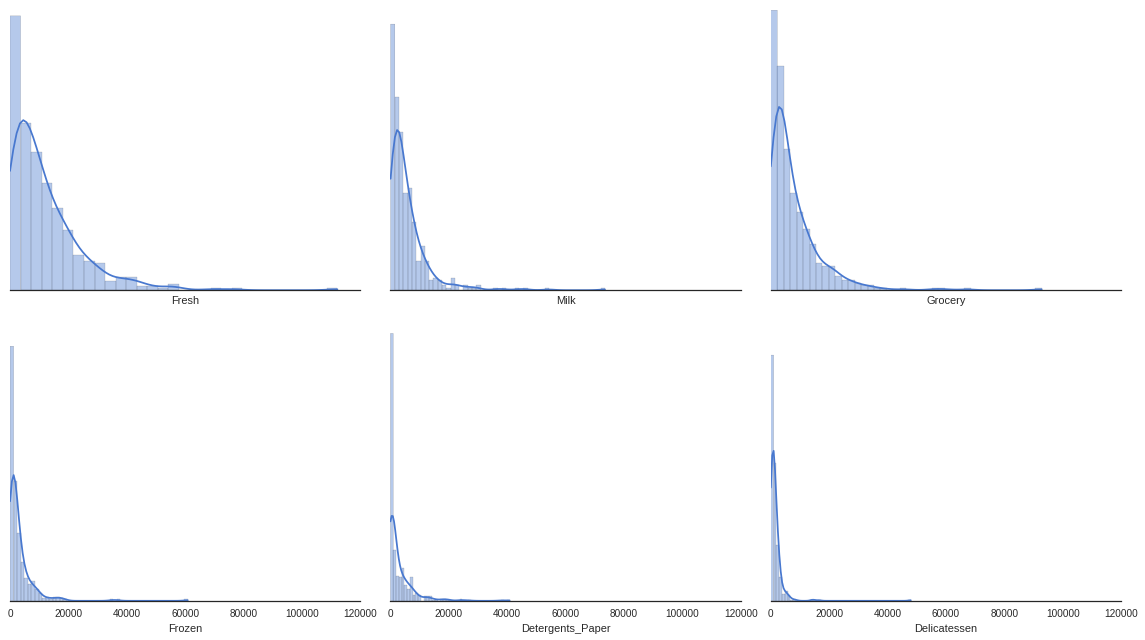

In [2]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2, 3, figsize=(16, 9), sharex=True)
sns.despine(left=True)

sns.distplot(data.Fresh, ax=axes[0, 0])
sns.distplot(data.Milk, ax=axes[0, 1])
sns.distplot(data.Grocery, ax=axes[0, 2])
sns.distplot(data.Frozen, ax=axes[1, 0])
sns.distplot(data.Detergents_Paper, ax=axes[1, 1])
sns.distplot(data.Delicatessen, ax=axes[1, 2])
plt.setp(axes, yticks=[])
plt.tight_layout()

__Answer__:

In PCA, for the first Principal Components (PC) I might expect a sort of blend of average customers/features who capture the most variance in the data with the largest highest-volume customers/categories ('Fresh') dominating.

In ICA, I might expect groups that are different/independent from each other. I might even expect one of the Independent Components (IC) put a heavy 'weight' on 'Fresh' as well.

## PCA

In [3]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
pca = PCA(n_components=data.shape[1]).fit(data)

# All features/variables are in the same 'monetary units' so we can choose
#  not to scale the data before PCA.
pca.fit(data)

# Print the components..
pca_names = ['PC-{}'.format(x) for x in xrange(1, 7)]

# Each row (each item from our list of pca.components) is a Principal Component 
# so we need to transpose the dataframe first, then label the columns
pc_components = pd.DataFrame(pca.components_).T

pc_components.columns = pca_names
pc_components.insert(0, 'Features', data.columns)

pc_components

,Features,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6
0,Fresh,-0.976537,-0.110614,-0.178557,-0.041876,0.015986,-0.015763
1,Milk,-0.121184,0.515802,0.509887,-0.645640,0.203236,0.033492
2,Grocery,-0.061540,0.764606,-0.275781,0.375460,-0.160292,0.410939
3,Frozen,-0.152365,-0.018723,0.714200,0.646292,0.220186,-0.013289
4,Detergents_Paper,0.007054,0.365351,-0.204410,0.149380,0.207930,-0.871284
5,Delicatessen,-0.068105,0.057079,0.283217,-0.020396,-0.917077,-0.265417


In [4]:
# Verify that the first PC matches our dataframe
# pca.components_[0]

In [5]:
# .. and the amount of variance in the data contained in each dimension
pca_var_explained = pd.DataFrame({'Explained Variance Ratio': pca.explained_variance_ratio_})

pca_var_explained.insert(0, 'PCA', pca_names)
pca_var_explained['Explained Variance Percent'] = pca_var_explained['Explained Variance Ratio'].apply(round, args=[3]).apply(lambda x: x*100)
pca_var_explained

,PCA,Explained Variance Ratio,Explained Variance Percent
0,PC-1,0.459614,46.0
1,PC-2,0.405172,40.5
2,PC-3,0.070030,7.0
3,PC-4,0.044023,4.4
4,PC-5,0.015022,1.5
5,PC-6,0.006138,0.6


/home/fch/GPU_2.7/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


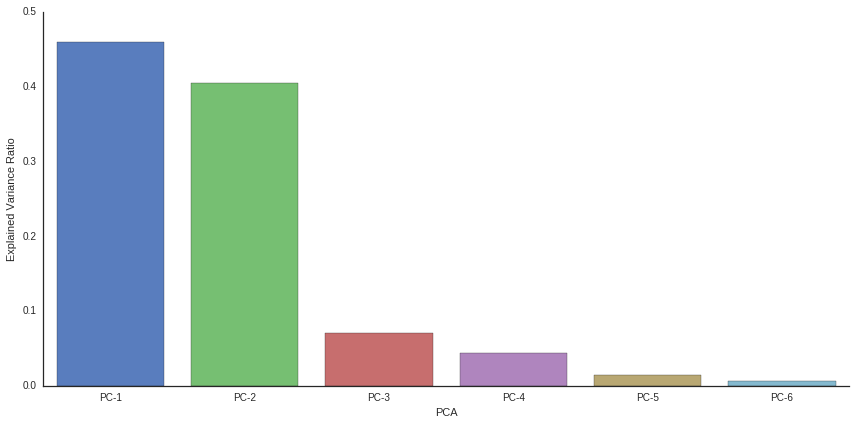

In [6]:
g = sns.factorplot(x="PCA", y="Explained Variance Ratio", data=pca_var_explained,
                   size=6, kind='bar', aspect=2)

---

**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

__Answer:__

The first PC contains about 46% of the variance of the dataset. The second contains about 40%. 

It quickly drops off from there to 7%, 4.4% 1.5%, and 0.6%. This quick dropoff, typically called an 'elbow',  is generally a good cutoff spot.

So because of this large dropoff, I would be confident in saying that 2 Principal Components, capturing about 86% of the data, would be enough to capture a large majority of the variance in the dataset.

---

In [7]:
def plot_pc(data, pc_columns, explained_var, PCA=True):
    sns.set(style="whitegrid")
    g = sns.PairGrid(data=data, size=5,
                     x_vars=pc_columns, y_vars=['Features'])
    
    g.map(sns.stripplot, size=10)

    

    # If these aren't PC components, don't include Variance explained labels
    # Set the x-bounds to be the same for both PCs
    if PCA:
        xlabels=['{}% Total Variance Explained by {}'.format(x, y) for x, y in zip(explained_var, pc_columns)]
        g.set(xlim=(-1.5, 1.5), ylabel="")
    else:
        xlabels=["" for x in explained_var]
        g.set(xlim=(-0.15, 0.15), ylabel="")
        
    for ax, xlabel, title in zip(g.axes.flat, xlabels, pc_columns):
        # Set a different title for each PC
        ax.set(title=title, xlabel=xlabel)
        
        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    sns.despine(left=True, bottom=True)

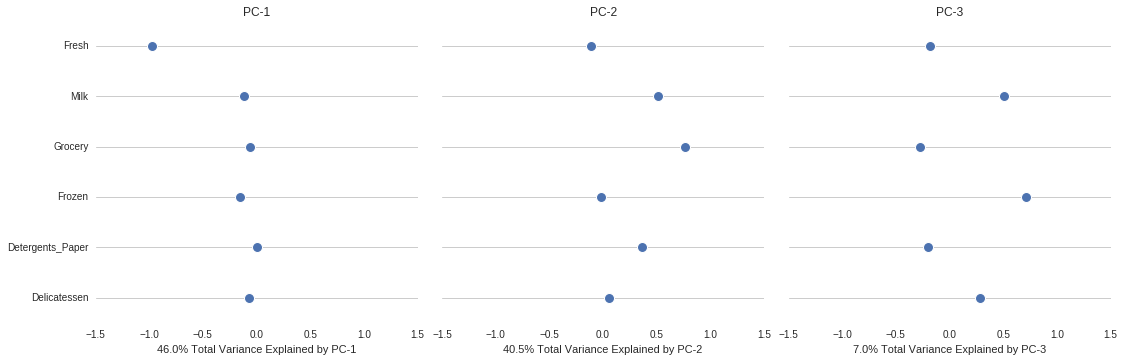

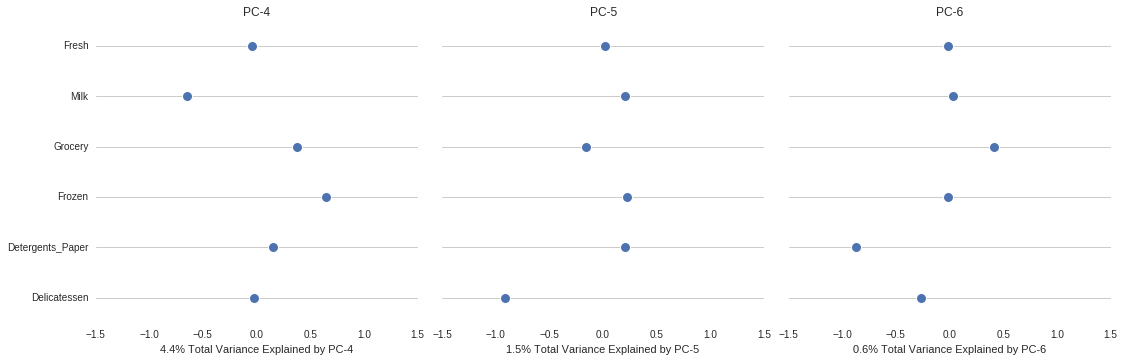

In [8]:
plot_pc(data=pc_components,
        pc_columns=pca_var_explained['PCA'][:3],
        explained_var=pca_var_explained['Explained Variance Percent'][:3])

plot_pc(data=pc_components,
        pc_columns=pca_var_explained['PCA'][3:],
        explained_var=pca_var_explained['Explained Variance Percent'][3:])

** Question 3**

What do the dimensions seem to represent? How can you use this information?

__Answer:__

Each dimension/value of each principal component represents a feature's contribution to that principal component. 

If we map the feature names back to their contributions and plot them, we can get an idea of what makes up each principal component.


In PCA, magnitude is king. Negative and positive values only really matter in the relative relationship between one variable to the others. 

In the plot above we can see that PC-1, which captures 46% of total variance, is dominated by Fresh products, reinforcing our initial intuition.

Milk, Grocery, and Detergents_Paper have more influence in the make-up of PC-2, which captures about 40% of the variance.

This might show two distinct groups of customers explaining most of the variance of our customers.

One group/PC would be customers who order more Fresh products than any other product. These customers would need Fresh products, probably preferably earlier in the day, for their customers to have fresh products. Since the sign for 'Fresh' is negative, customers who had highly negative scores on PC-1 would fall into this group.


PC-2 on the other hand is made up of customers who prefer Milk, Grocery, and Detergents_Paper over other products. These customers might be more receptive to night time deliveries. Since the signs are positive for Milk, Grocery, and Detergents_Paper, customers who had highly positive scores would fall into this group.

These basis vectors (PCs) can be used to identify different groups of customers with different needs to be able to tailor services to each group. Those who need fresh products may be willing to pay a slight premium to ensure regular morning deliveries. Others without those needs, may be more receptive to night deliveries. 

Also, depending on the magnitude of the stores' scores after multiplying by these basis vectors, those with very high scores, may be more receptive to bulk deliveries.

Let's project our stores into this PCA space, and examine the first 2 PCs in a scatterplot (biplot) to get a quick feel for what this looks like.

In [9]:
pc_score_vectors = pca.transform(data)

pc_score_vectors = pd.DataFrame(pc_score_vectors, columns=pc_components.columns[1:])
pc_score_vectors.head() # First 5 stores projected into PCA space

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6
0,-650.022122,1585.519090,-95.390644,-4540.780481,356.637118,226.711848
1,4426.804979,4042.451509,1534.804744,-2567.655659,44.394283,468.938017
2,4841.998707,2578.762176,3801.384790,-2273.494337,-5245.385438,-2141.123329
3,-990.346437,-6279.805997,1396.959815,3310.006074,-318.152336,247.816335
4,-10657.998731,-2159.725815,-20.042982,-172.715386,-3188.717122,-510.145095


First 5 stores projected into PCA space

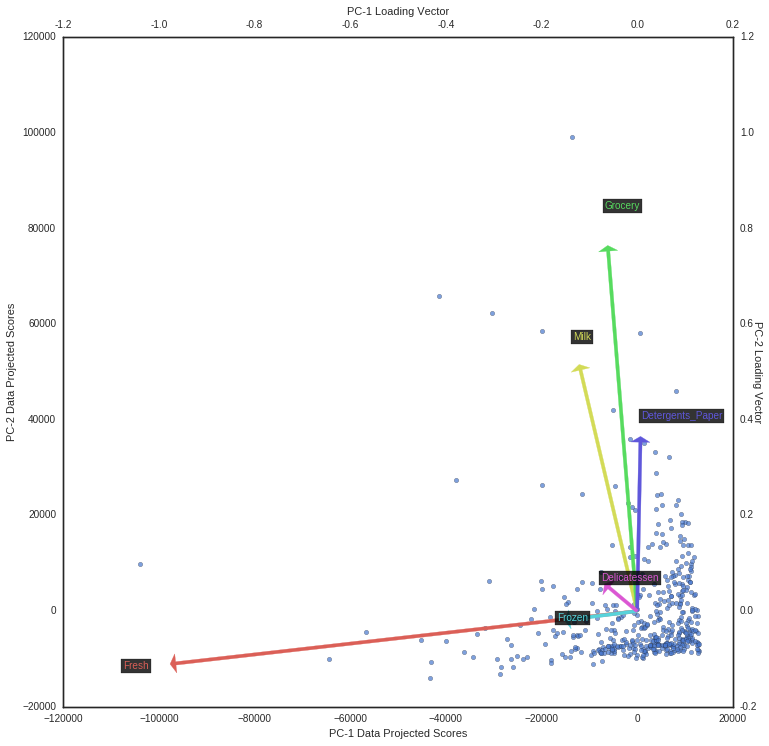

In [10]:
import matplotlib.patches as patches

sns.set_style('white')

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(111, aspect='equal')
ax2 = ax.twiny() # Add copy for separate x-axis
ax3 = ax.twinx() # Add copy for separate y-axis

BASIC_VEC_MULT_CONSTANT = 100000.

# Add each PC basis vector from first 2 Principal Components
for pc1, pc2, rgb_color, feature in zip(pc_components['PC-1'], 
                                        pc_components['PC-2'], 
                                        sns.color_palette("hls", 6),
                                        pc_components['Features']):
    # length_includes_head=True is needed so the 'basis_vector_mult_constant'
    #  can used to derive locations for the second xy-axis as well
    p = patches.FancyArrow(0, 0, pc1*BASIC_VEC_MULT_CONSTANT, pc2*BASIC_VEC_MULT_CONSTANT,
                           width=700, fc=rgb_color, ec=rgb_color,
                           head_width=4000, head_length=1200, length_includes_head=True)

    ax.add_patch(p)
    # add 10,000 to push the labels out a bit further from the basis vector arrows
    ano = ax.annotate(feature,
                      xy=(pc1*(BASIC_VEC_MULT_CONSTANT+10000),
                          pc2*(BASIC_VEC_MULT_CONSTANT+10000)), 
                      color=rgb_color,
                      fontsize=10,
                      bbox=dict(color='black', alpha=0.8, pad=2)) # Change text bounding box attrib.

ax.scatter(pc_score_vectors['PC-1'], pc_score_vectors['PC-2'], alpha=0.7)
ax.set_xlabel('PC-1 Data Projected Scores')
ax.set_ylabel('PC-2 Data Projected Scores')

#-------- Add PC Loading Vector x/y axes BEGIN

def tick_function(x):
    V = x/BASIC_VEC_MULT_CONSTANT
    return ['%.1f' % z for z in V]

ax2.set_xlim(ax.get_xlim())
ax3.set_ylim(ax.get_ylim())

ax2.set_xticks(ax.get_xticks())
ax3.set_yticks(ax.get_yticks())

# Project the original x/y axes to the opposite side, dividing by the basis vector mult constant to
#  put it on the same scale as the PC loading vectors.
ax2.set_xticklabels(tick_function(ax.get_xticks()))
ax3.set_yticklabels(tick_function(ax.get_yticks()))

ax2.set_xlabel('PC-1 Loading Vector')
ax3.set_ylabel('PC-2 Loading Vector', rotation=270)
#-------- Add PC Loading Vector x/y axes END

sns.set_style('whitegrid')

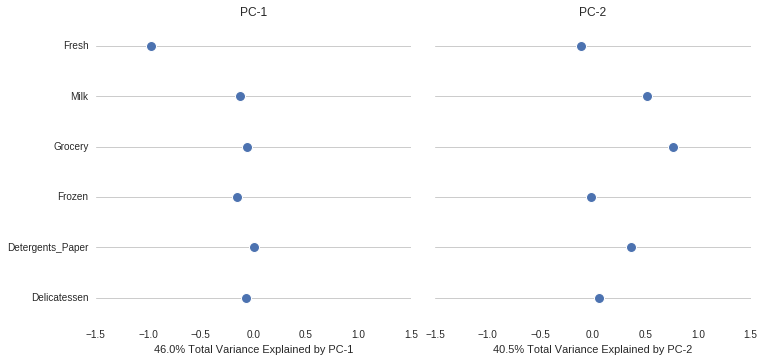

In [11]:
plot_pc(data=pc_components,
        pc_columns=pca_var_explained['PCA'][:2],
        explained_var=pca_var_explained['Explained Variance Percent'][:2])

Here we can better see that there are indeed two different types of stores, those that tend toward 'Fresh', and those that tend toward Milk, Grocery, and Detergents_Paper. There are also many small stores tending away from the average at 0, yet still preferring certain products over others.

There look to be potentially more than a couple of subgroups, that a clustering algorithm like K-Means or Gaussian Mixture Models may be able to better uncover.

---

### ICA

In [12]:
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

ica = FastICA(n_components=6,random_state=1337)

S_ = ica.fit_transform(data_scaled)
A_ = ica.mixing_

ic_names = ['IC-{}'.format(x) for x in xrange(1, 7)]

# Print the independent components; transpose into IC columns
ica_components =  pd.DataFrame(ica.components_).T
ica_components.columns = ic_names

ica_components.insert(0, 'Features', data.columns)
ica_components

,Features,IC-1,IC-2,IC-3,IC-4,IC-5,IC-6
0,Fresh,0.003334,0.004429,-0.004986,0.001681,-0.010866,-0.050148
1,Milk,-0.008653,0.036004,-0.001965,-0.066168,-0.001788,0.006143
2,Grocery,-0.124390,0.009121,-0.006488,0.065250,0.008139,0.008137
3,Frozen,0.006757,0.000415,-0.002582,0.002918,0.054070,0.003375
4,Detergents_Paper,0.134901,0.009178,0.002268,0.003750,-0.002757,-0.010452
5,Delicatessen,0.014754,-0.012884,0.051198,0.012948,-0.016611,0.002694


In [13]:
# Confirm that our column for IC-1 matches the first item entry from ica.components_
# ica.components_[0]

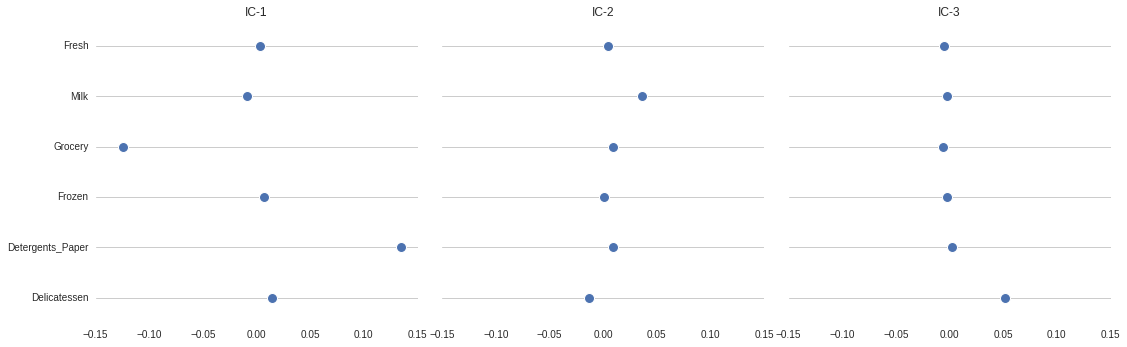

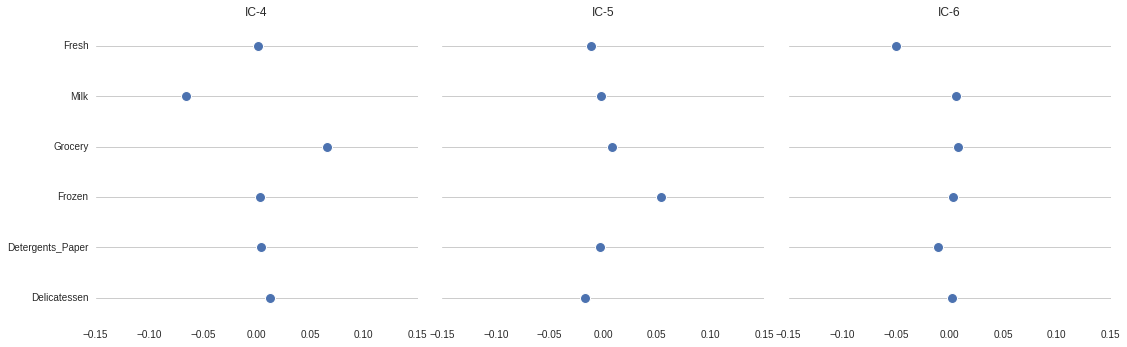

In [14]:
plot_pc(data=ica_components, pc_columns=['IC-1', 'IC-2', 'IC-3'], explained_var=['', '', ''], PCA=False)
plot_pc(data=ica_components, pc_columns=['IC-4', 'IC-5', 'IC-6'], explained_var=['', '', ''], PCA=False)

**Question 4:**

For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

__Answer:__

The labeling/ordering and/or sign of the Independent Components (IC's) might change after re-running ICA, but the same six IC's are always reperesented.

This is because FastICA is an iterative algorithm with randomized initial weights, but the FastICA components are independent so ordering/sign shouldn't matter anyway.

In order to describe a specific order of IC's and give their interpetations, we've set a random seed. Without a random seed, IC-1 might switch places with IC-4, or even switch signs, but the same ICs should always be present.



- __IC-1__: Stores who score positive scores on this IC would order much more Detergents_Paper than average, and much less Groceries. This might be something like a drugstore. Stores with negative scores would tend to the opposite, higher groceries and lower detergents and paper.

- __IC-2__: Stores here look to be the most average stores of all the ICs, slightly preferring milk and shying away from delicatessen products. Maybe coffee shops due their predilection for milk products.

- __IC-3__: Stores with positive scores here look to be deli's, preferring Delicatessen products over all others. 

- __IC-4__: Stores here have a preference toward Grocery and away from milk (or vice versa depending on if they score negatively or postively on this IC.) Those stores wth negative scores might also be pure coffee shops, shying away from grocery heavily while tending toward milk. Those with positive scores might be grocers without a dairy section.

- __IC-5__: Stores with a higher weight on Frozen products. Higher positive scores might be stores who specialize in frozen goods, while scores toward zero might be those who are average stores without any frozen section (negative scores are harder since there aren't really negative weights on this IC).

- __IC-6__: Stores with higher weight on Fresh products. Stores with high negative stores would specialize in Fresh products like [Whole Foods](http://www.wholefoodsmarket.com/) or local green grocers. Stores with scores tending to zero would have very low Fresh compared to other products.

These IC basis vectors could be used to identify independent types of customers. These types could be used to classify customers into groups that might be more receptive to different delivery schedules/types (i.e. morning vs night, regular vs bulk.)

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**Question 5:**

What are the advantages of using K Means clustering or Gaussian Mixture Models?

### K-means:

K-means clustering seeks to find K (a hyper parameters we choose) different clusters which have the smallest within-cluster variation. 

The within-cluster variation is typically measured by the average of the pairwise squared Euclidian distances between the observations for each of the clusters. K-means attempts to minimize the sum of this within-cluster variation over all of the clusters.

This is equivalent to minimizing the sum of squares of each observation's feature minus the mean of each of those features within each cluster (then multiplying by 2) [(Hastie et al, 6th Ed. 2015.)](http://www-bcf.usc.edu/~gareth/ISL/index.html) 

So in essence an average of each cluster, called a centroid, is computed and the distances of each observation from that centroid in that cluster are squared and summed. 

So, after an initial random assignment, this within-cluster variation is minimized by:

1. Computing cluster centroids.

2. Assign each observation to a cluster centroid based on our distance function (typically Euclidian distance)

3. Repeat 1 and 2 until observations are no longer reassigned to different clusters.

__Weaknesses__:

In K-means, we are making 'hard' assignments saying every observation belongs uniquely to only one of the K clusters. This can be problematic if most obervations truly belong to a small number of cluster/subgroups, and some small number are outliers and are different than all the other observations.

Forcing the inclusion of these outliers with very large distances from centroids into our clusters can cause the clusters to become distorted, and cause our clusters to be less representative of the true subgroups/clusters in our data.

But intuitively, we might think that observations closer to the K-cluster centroids should be more likely to belong to that cluster than those that are on the borders of the cluster. 

Mixture models, like the one discussed next, use a sort of 'soft' assignment to clusters to alleviate some these concerns.

K-means can also be less robust, as randomly removing (or adding) observations, can have a large effect on the different cluster shapes (especially when outliers are involved.)

Finally, since K-means seeks to minimize within-cluster sum of squares, it can have trouble with clusters with [unequal variance](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#example-cluster-plot-kmeans-assumptions-py), clusters whose variance are not spherical, and [clusters which don't have roughly the same number observations](http://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means).

In our case, a mixture model may make more suitable assumptions given our data.

### Gaussian Mixture Models:

In Gaussian mixture models, we again have a hyper parameter K, which this time is the assumed number of underlying Gaussian distributions that may have generated the data. 

We can then introduce _latent_ variables ($z_k$) which are 1 if the observation belongs to the $k^{th}$ Gaussian, and 0 otherwise. 

To give a soft assignment, we can define weights for these _latent_ variables (mixing coefficients, $\pi_k$) to each _latent_ variable.

These mixing coefficients will sum to 1 (over all K-Gaussians for each observation), and will thus be posterior probabilities of the observation having been generated by the $k^{th}$Gaussian cluster given it's mean ($\mu_k$) and variance/covariance ($\sigma_k^2$).

Thus, the $k^{th}$ Gaussian with the highest probability would be the 'soft' cluster assigned for each observation, and those observations halfway between two different Gaussians would have almost equal probability of belonging to either cluster/Gaussian. 

To train the model, we then want to iteratively adjust the parameters of each Gaussian ($\mu_k$, $\sigma_k^2$) and a mixing coefficient $\pi_k$, to maximize the probability of the data [(Bishop, 2006.)](http://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738)

This can be done by applying [Bayes' Rule](https://en.wikipedia.org/wiki/Bayes%27_rule): 

1. ___Initialize___ means $\mu_k$, variances/covariances $\sigma_k^2$, and mixing coefficients $\pi_k$ (either randomly or by running K-means first to get an estimate), then evaluate the log likelihood of the data given these parameters.

2. __Expectation:__ Compute the probabilities that each observation belongs to each Gaussian given that Gaussian's $\mu_k$ and $\sigma_k^2$

3. __Maximization:__ Compute the means $\mu_k$ and $\sigma_k^2$ for each Gaussian/cluster$_k$ given the observations that belong to it.

4. __Evaluate__ the log likelihood of the data given the parameters.

5. ___Repeat___ 2, 3, 4 until convergence criteria is met.

___Note: If we simply take the argmax of $\lambda_k$ (highest mixing coeffient) and set it to 1 (100%), then this would be a 'hard' assignment to that cluster, and would essentially just be K-means Clustering (saying that each point belongs uniquely to one cluster.)___

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [16]:
def plot_clusters(clf, reduced_PCA_data, princ_comps, pc_scores, model):
    
    # Obtain labels for each point in mesh. Use last trained model.
    reduced_PCA_data = np.array(reduced_PCA_data)
    
    # Plot the decision boundary by building a mesh grid to populate a graph.
    x_min, x_max = reduced_PCA_data[:, 0].min() - 1, reduced_PCA_data[:, 0].max() + 1
    y_min, y_max = reduced_PCA_data[:, 1].min() - 1, reduced_PCA_data[:, 1].max() + 1
    hx = (x_max-x_min)/1000.
    hy = (y_max-y_min)/1000.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))
    
    if model == 'KMeans':
        centroids = clf.cluster_centers_
    elif model == 'GMM':
        centroids = clf.covars_
    else:
        raise Exception("Unsupported Model: Use 'KMeans' or 'GMM'")
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    fig = plt.figure(1, figsize=(16, 9))
    
    #-------------------- Superimpose top 2 PC vectors BEGIN
    ax = fig.add_subplot(111, aspect='equal')
    
    BASIC_VEC_MULT_CONSTANT = 80000.
    # Add each PC basis vector from first 2 Principal Components
    for pc1, pc2, rgb_color, feature in zip(princ_comps['PC-1'], 
                                            princ_comps['PC-2'], 
                                            sns.color_palette("hls", 6),
                                            princ_comps['Features']):
        # length_includes_head=True is needed so the 'basis_vector_mult_constant'
        #  can used to derive locations for the second xy-axis as well
        p = patches.FancyArrow(0, 0, pc1*BASIC_VEC_MULT_CONSTANT, pc2*BASIC_VEC_MULT_CONSTANT,
                               width=700, fc=rgb_color, ec=rgb_color,
                               head_width=4000, head_length=1200, length_includes_head=True)

        ax.add_patch(p)
        # add 10,000 to push the labels out a bit further from the basis vector arrows
        ano = ax.annotate(feature,
                          xy=(pc1*(BASIC_VEC_MULT_CONSTANT+10000.),
                              pc2*(BASIC_VEC_MULT_CONSTANT+10000.)), 
                          color=rgb_color,
                          fontsize=10,
                          bbox=dict(color='black', alpha=0.8, pad=2)) # Change text bounding box attrib.

    ax.scatter(pc_scores['PC-1'], pc_scores['PC-2'], alpha=0.7)
    ax.set_xlabel('PC-1 Data Projected Scores')
    ax.set_ylabel('PC-2 Data Projected Scores')
    #-------------------- Superimpose top 2 PC vectors END

    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_PCA_data[:, 0], reduced_PCA_data[:, 1], 'k.', markersize=2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())

    plt.show()

In [17]:
# First we transform the data using PCA to capture variation
pc_score_vectors = pca.transform(data)
pc_score_vectors = pd.DataFrame(pc_score_vectors, columns=pc_components.columns[1:])

# Then we reduce the data to two dimensions by selecting only the first two PCs
reduced_data = pc_score_vectors[['PC-1', 'PC-2']] # Pull out onlt 
reduced_data[:10]  # print up to 10 elements


,PC-1,PC-2
0,-650.022122,1585.519090
1,4426.804979,4042.451509
2,4841.998707,2578.762176
3,-990.346437,-6279.805997
4,-10657.998731,-2159.725815
5,2765.961593,-959.870727
6,715.550892,-2013.002266
7,4474.583667,1429.496972
8,6712.095397,-2205.909156
9,4823.634354,13480.559205


First we transform the data using PCA to capture most of the variation. 

Then we reduce the data to two dimensions by selecting only the first two Principal Components.

Finally, we can plot the different numbers of clusters produced by our K-means and Gaussian Mixture Models.

We'll start with K-means.

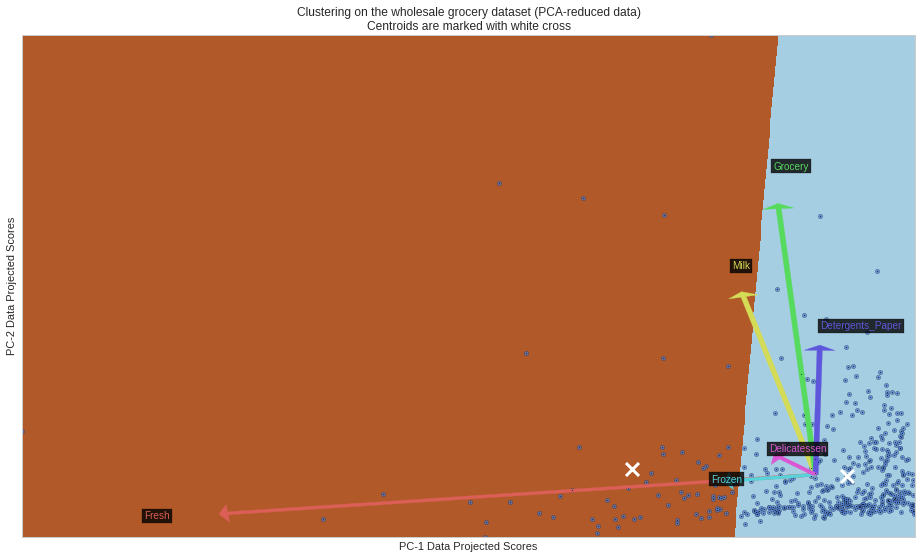

In [19]:
clusters = KMeans(n_clusters=2).fit(reduced_data)
plot_clusters(clusters, reduced_data, pc_components, pc_score_vectors, model='KMeans')

___For this visualization, we have superimposed our scaled up PC-1 and PC-2 vectors onto a plot of the data projected/scored into the PC space. We have also colored each clusters region, and added a white 'X' at the cluster centroid.___


__K-means, 2 clusters:__

At 2 clusters, K-means seems to try to separate those with very high 'Fresh' scores from the rest. This doe not seem very optimal since there looks to be a lot of variation within the 'blue' cluster.

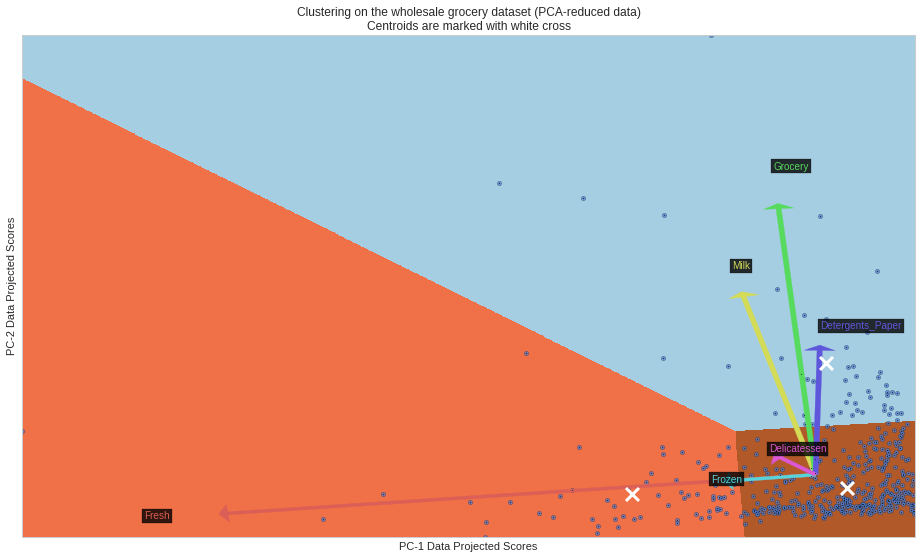

In [20]:
clusters = KMeans(n_clusters=3).fit(reduced_data)
plot_clusters(clusters, reduced_data, pc_components, pc_score_vectors, model='KMeans')

__K-means, 3 clusters:__

At 3 clusters, we now have high large order volume customers separated in two distinct groups - those with a volumn of 'Fresh' and those that tend toward Milk, Grocery, and Detergents_Paper.

There does seem to still be a lot variation between those two sub-groups in the low-volume 'brown' cluster of those centered around the mean. 

This clustering is not quite ideal.

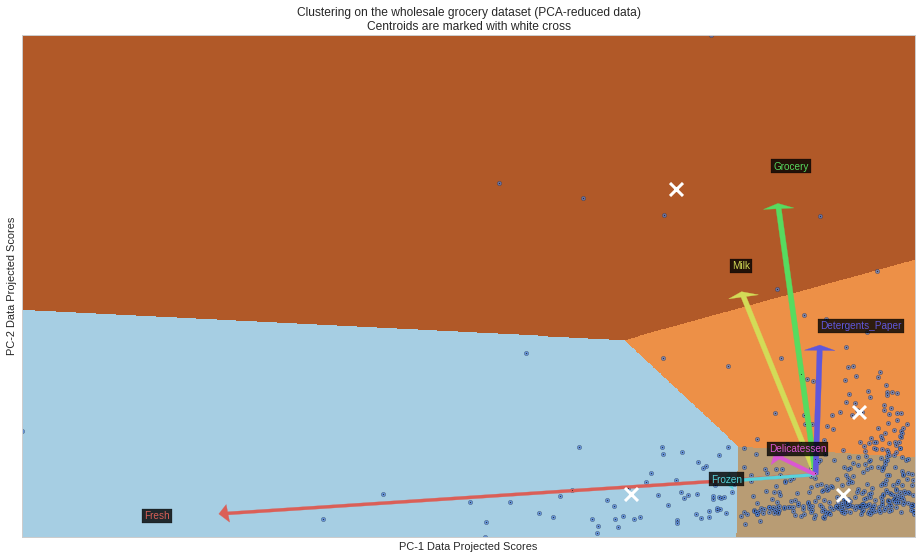

In [21]:
clusters = KMeans(n_clusters=4).fit(reduced_data)
plot_clusters(clusters, reduced_data, pc_components, pc_score_vectors, model='KMeans')

__K-means, 4 clusters:__

At 4 clusters, we get better separation but the different, possibly elliptical, distributions toward PC-1 and PC-2 seem to be split down the middle by the cluster borders.

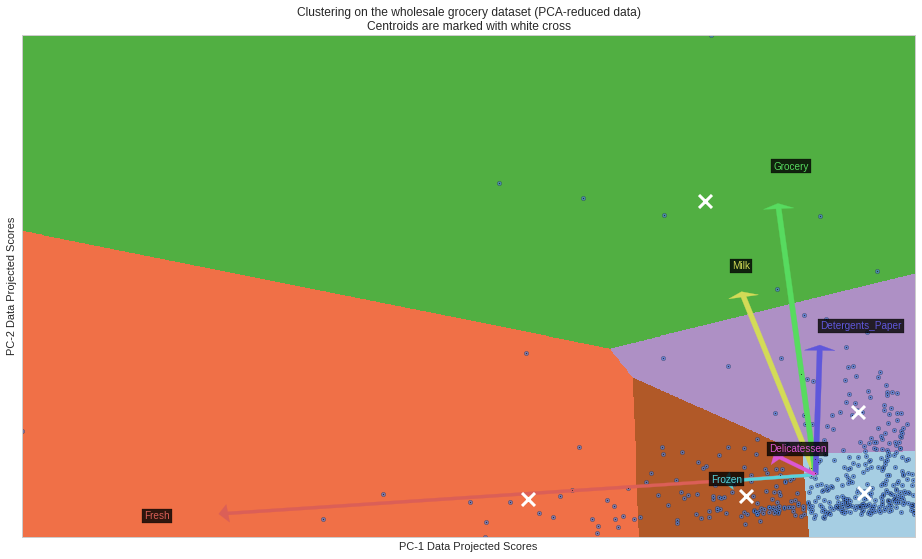

In [28]:
clusters = KMeans(n_clusters=5).fit(reduced_data)
plot_clusters(clusters, reduced_data, pc_components, pc_score_vectors, model='KMeans')

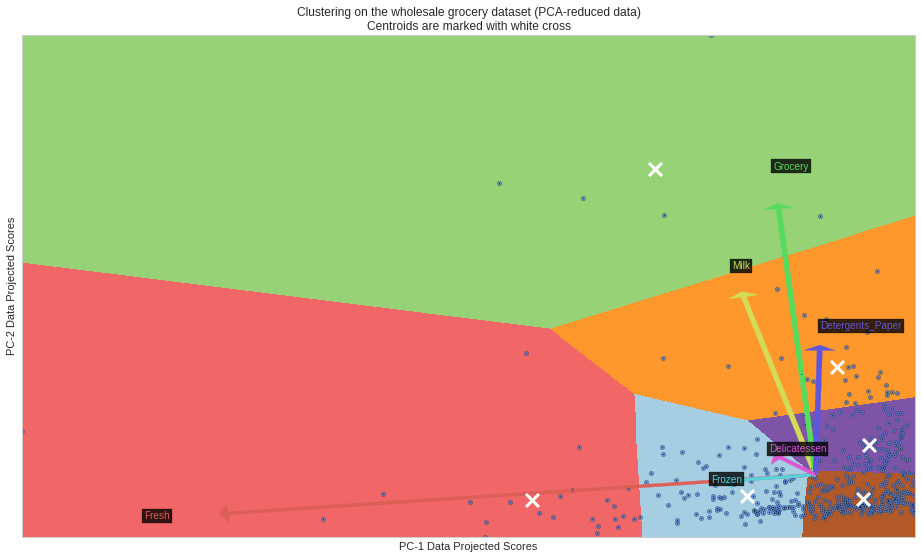

In [29]:
clusters = KMeans(n_clusters=6).fit(reduced_data)
plot_clusters(clusters, reduced_data, pc_components, pc_score_vectors, model='KMeans')

__K-means, 5/6 clusters:__

Five and six clusters are more of the same; possibly elliptical distributions are split by cluster borders.

But K-means does an ok job of separating high, medium, low scoring customers toward PC-1 (dominated by Fresh) and PC-2 (dominated by Milk, Grocery, and/or Detergents_Paper.)

--- 

Next, we take a look at the Gaussian Mixture Model (GMM).

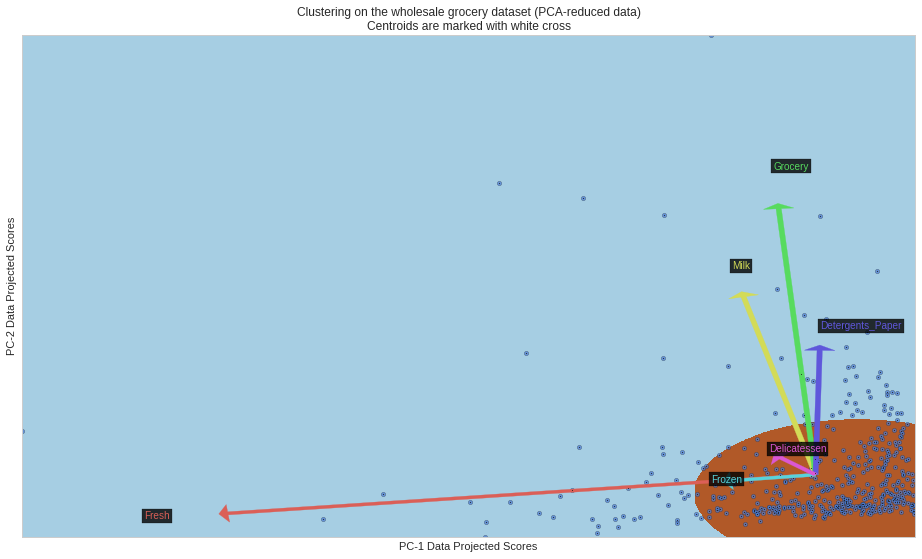

In [34]:
mixtures = GMM(n_components=2).fit(reduced_data)
plot_clusters(mixtures, reduced_data, pc_components, pc_score_vectors, model='GMM')

___Here we have a similar plot, with the Gaussians plotted instead of the K-means borders. The borders are where highest probability for a customer switches from one Gaussian to another. Points near the border are almost equally like to belong to either of the two Gaussians.___

___GMM, 2 Gaussians:___

At 2 Gaussians, we can see that high volume/score customers are separated from those near the origin (the average.) 

But we can also quickly see that, at 2 Gaussians, this inner distribution is elliptical and elongated on the PC-1 ('Fresh') axis.

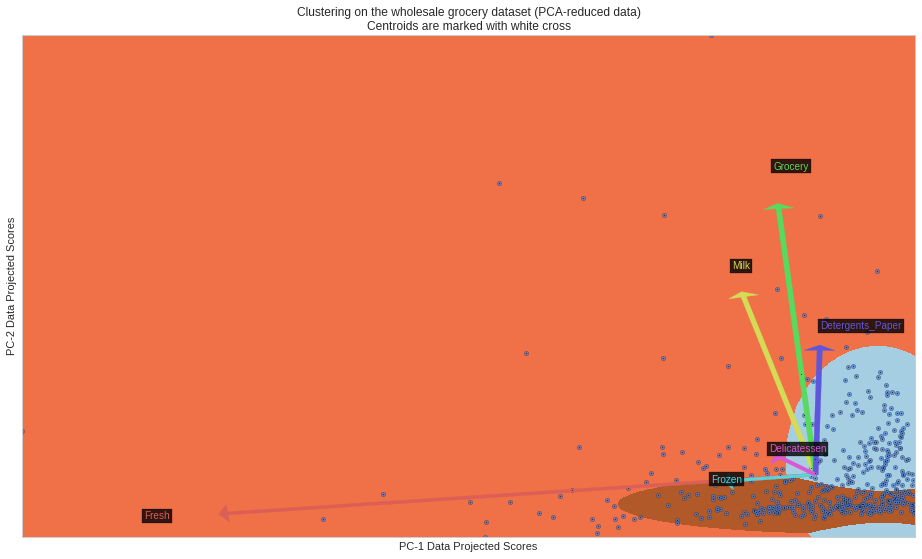

In [35]:
mixtures = GMM(n_components=3).fit(reduced_data)
plot_clusters(mixtures, reduced_data, pc_components, pc_score_vectors, model='GMM')

___GMM, 3 Gaussians:___

Now we have 3 distributions that seem to capture the particular distrbutions of this data quite well about the origin. 

All high volumn/score customers are still lumped into one sort of 'outlier' distribution though.

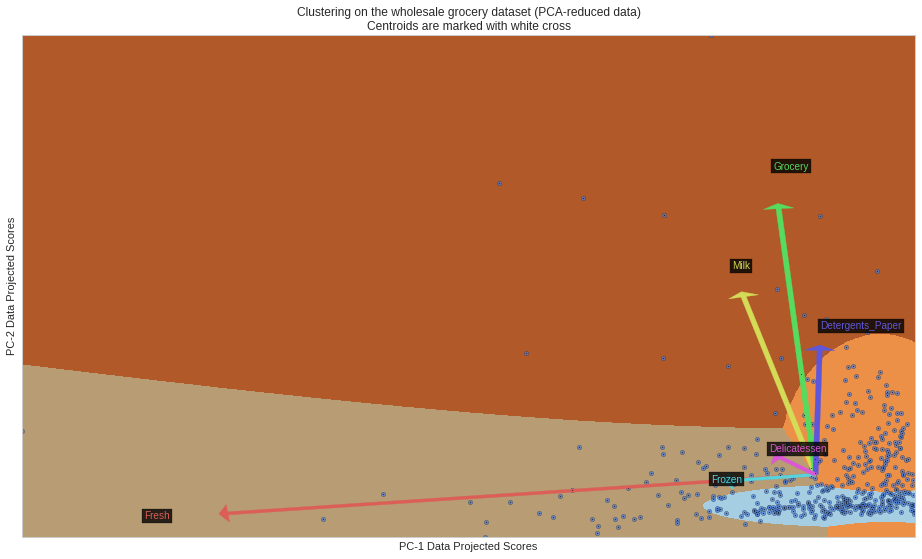

In [36]:
mixtures = GMM(n_components=4).fit(reduced_data)
plot_clusters(mixtures, reduced_data, pc_components, pc_score_vectors, model='GMM')

___GMM, 4 Gaussians:___

Here at 4 Gaussians, the high volumn/score customers are separated better by their type of products that each PC vector favors.

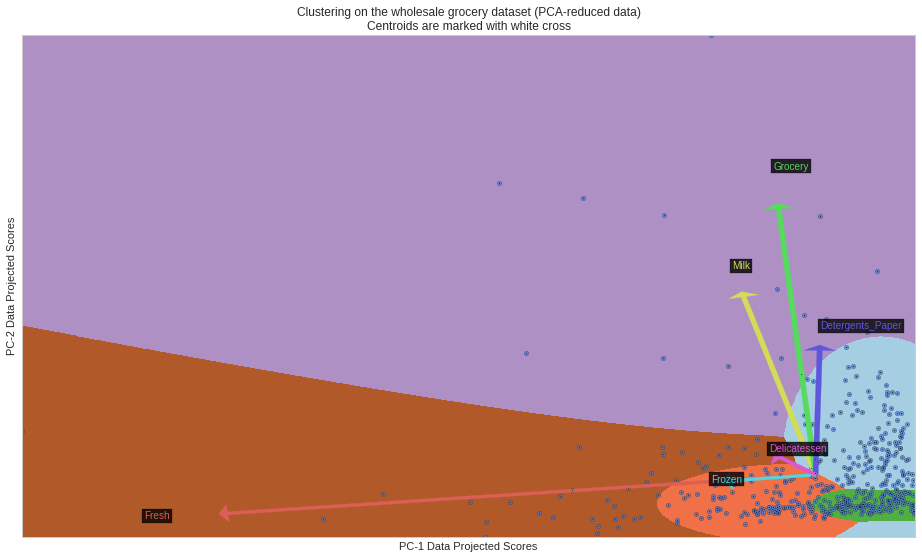

In [37]:
mixtures = GMM(n_components=5).fit(reduced_data)
plot_clusters(mixtures, reduced_data, pc_components, pc_score_vectors, model='GMM')

___GMM, 5 Gaussians:___

At 5 Gaussians, we have another subgroup about the origin, this time encompassing those influenced by PC-1 but that go in a positive direction. These are those customers who order more of other products, and almost no Fresh products.

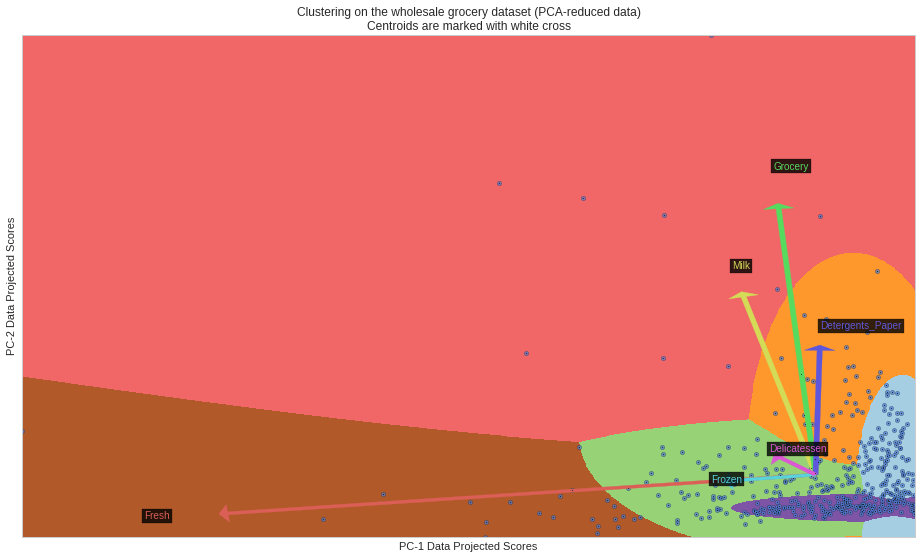

In [38]:
mixtures = GMM(n_components=6).fit(reduced_data)
plot_clusters(mixtures, reduced_data, pc_components, pc_score_vectors, model='GMM')

___GMM, 6 Gaussians:___

At 6, this changes a little and we now have a smaller 'purple' cluster that is defined mostly by it's PC-1 score. 

There's also a 'blue' cluster that shies away from the PC-1 fresh score, and heavily favors the Milk, Grocery, Detergents_Paper (MGD) direction.  

A 'green' cluster encompasses Delicatessen as well as Fresh and Frozen.

'Orange' is closer to origin (mean) on PC-1, but still favors MGD heavily. 

The high volume clusters are still separated by the PC vector.

---

### Best choice of algorithm and number of clusters

The Gaussian Mixture Model seems to better fit our data when modeling clusters, but choosing the exact number is more difficult. 

Three clusters seems to do well at separating high and low volume, and within low volume, it does well at separating Fresh from Milk/Grovery/Detergents_Paper.

But more Gaussians also seem to better capture some of the nuances of the more dense area closer to the origin.


Luckily, for Gaussian Mixture Models, there are two major criterion scoring metrics for model selection based on the likelihood function - the [Bayesian Information Criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) and the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion).

They both introduce penalty terms for model complexity but the BIC is a bit more strict with a larger penalty. We'll choose BIC, but they should generally give comparable model choices.

In the case of BIC, lower is better, and a difference greater than 10 indicates _very strong evidence_ for choosing one model over another [(Raftery, 1995)](https://www.stat.washington.edu/raftery/Research/PDF/socmeth1995.pdf).

So we can train different models with different numbers of Gaussians to help us get an idea where this model complexity trade-off might be optimal.

We'll plot these scores to get a better visual indication.

In [31]:
all_gmm = []
for i in np.arange(1, 13):
    gmm = GMM(n_components=i).fit(reduced_data)
    all_gmm.append([i, gmm.bic(reduced_data), gmm])

gmm_models = pd.DataFrame(all_gmm, columns=['n_components', 'BIC', 'model'])

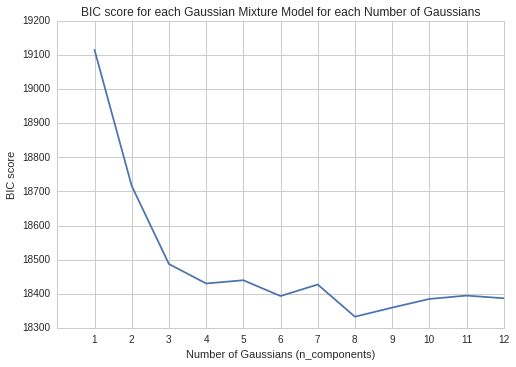

In [32]:
plt.plot(gmm_models["n_components"], gmm_models["BIC"], '-')
plt.xticks(xrange(1, 13))
plt.xlabel('Number of Gaussians (n_components)')
plt.ylabel('BIC score')
plt.title('BIC score for each Gaussian Mixture Model for each Number of Gaussians')
plt.show()

We can see that BIC score is lowest at 8 Gaussians - a number we didn't even try in our initial exploration!

We can check the difference between models with 7 or 8 to make sure this difference is more than 10.

In [33]:
# Much greater than 10; best model at 8 n_components
gmm_models[gmm_models['n_components'] == 7]['BIC'].values - \
gmm_models[gmm_models['n_components'] == 8]['BIC'].values

array([ 94.43182654])

A difference of more than 90 indicates 8 Gaussians might be the optimal number according the BIC.

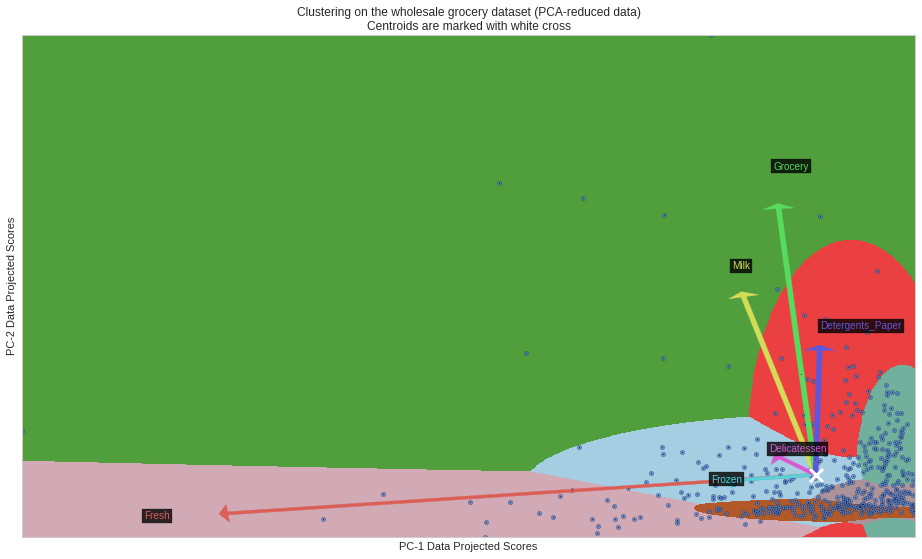

In [119]:
temp_gmm = gmm_models[gmm_models['n_components'] == 8]['model'].values[0]
plot_clusters(temp_gmm, reduced_data, pc_components, pc_score_vectors, model='GMM')

**Question 7:**

What are the central objects in each cluster? Describe them as customers.

___GMM, 6 Gaussians:___

Plotting this model, we can see:

- ___Dark Brown:___ A smaller distribution about the origin dominated almost solely by the PC-1 score (Fresh/Frozen). The might be smaller fresh markets.

- ___Light Brown:___ These are all positive on the PC-1 vector, showing very little influence from Fresh/Frozen, and more Milk/Grocery/Detergents_Paper. These might be smaller stores which don't require Fresh/Frozen products as much as other products such as convenience stores.

- ___Cyan:___ A distribution pushed away toward very little Fresh influence on PC-1, but heavily influenced by Detergent_Paper. These might be drug stores like CVS or Walgreens.

- ___Red:___ Almost the same as cyan, but more influenced by Grovery and Milk as well, and not so negatively influenced by Fresh/Frozen. These are larger customers and be tending toward mid-size supermarkets, or even large coffee shops with the influence of Milk.

- ___Light Blue:___ Here we now have a distribution that captures Delicatessan influence more heavily, with some influence from Fresh/Frozen as well. These loook to be Deli's, tending toward Delicatessen and Fresh.

- ___Pink:___ Here are the big volume Fresh/Frozen customers. Very large Fresh product oriented stores like Whole Foods.

- ___Green:___ Here are the other big volume Milk/Grocery/Detergents_Paper customers. Very large everything else like Walmart.

---

# Conclusions

**Question 8:**

Which of these techniques did you feel gave you the most insight into the data?

Gaussian Mixture Models (GMM) seemed to carry the right assumptions for our data. Gaussian distributions with different means seemed to better model the elliptical distributions of our data.

Also, GMM might be better in this case because there seem to be a small of clusters of similar customers, while a small subset of customers are quite different from each other and all other customers. These may be those outliers that order a very high volume of some combination of Del, Milk, etc. 

It also seemed to better handle the outlier high volume stores, without distorting the probabilistic boundaries in the denser area near the origin.

Conversely, K-means seemed to require assumptions like spherical clusters, equal variance, hard assignments, etc. (discussed in more detail earlier in K-means weaknesses) that didn't necessarily apply to our data.


---

**Question 9:**

How would you use that technique to help the company design new experiments?

__Answer:__

I might use GMM to identify and target specific clusters/types of customers with specific delivery schedules.

Once identified, I would test changes to delivery schedules to random (experiment) customers who were near the centers of these different clusters. This is to ensure the highest probability that this change might be appropriate and not generate complaints and customer loss. The changes tested regular/bulk and morning/night would depend on the cluster in question.

---

We have a cluster of small businesses dealing in mostly 'Fresh' products who would want regular morning deliveries. These might be unchanged at first since they are the most likely to require regular morning deliveries.

Other smaller to lower mid-size groups ordering very little fresh in comparison to other types of products might be ok if switched to regular or semi-regular night deliveries.

The upper mid-size to larger clusters/types might be ok with bulk deliveries. Though they might prefer more regular/earlier deliveries as well if they specialize in Fresh products.

--

Then once changes are made for this random subset in each cluster, we can measure the difference over a specified amount of time for complaints/customers lost versus the unchanged (control) subset in each cluster. This would basically amount to using hypothesis testing and significance testing techniques to analyze the effects of any changes made.

Note: We might also have to be careful with this analysis since 'new experience' reactions (change aversion) can be unavoidable to some degree when some fundamental changes to services are made. We also have make sure the length of time to allow customers to adjust is sufficient enough to make a robust decision.

---

**Question 10:**

How would you use that data to help you predict future customer needs?

__Answer:__

Once we have robust model, we could predict current customers' future scheduling needs depending on the their orders, which cluster they were in, and how close to the cluster center they are. We could also contact those near the borders for their explicit feelings towards changes as they are closer to belonging to two different Gaussians/clusters.

For future customers, it's simply a matter of projecting their first orders (or predicted orders) into this space using the PC components and GMM means to see where they might best fit into the initial shipping plans.

And of course, continually updating our models as we get more data. This is especially true once we start to get data on our customers' attitudes towards our services. This can be attained with customer surveys with yes/no questions and Likert scale ratings. More individual customer data such demographics might also help as well.

Through surveys, we can find which customers are happy with whichever schedules they are on, and to what extent. Once we have a this information (i.e. a dependent/target variable to predict), this becomes a much more defined supervised learning problem that can be approached with any myriad techniques.

This might include using our PCA components and cluster assignments as input to Linear Regression, Random Forests, SVM, Nueral Networks, etc to predict customer sentiment (survey results.)